In [1]:
# === 📦 IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

# Handle imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [3]:
# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv("dataset_med.csv")

In [5]:
df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [6]:
# === 🎯 Feature Engineering ===

# Age group
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 80, 120], labels=['young', 'middle', 'senior', 'elderly'])

# BMI group
df['bmi_group'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal', 'overweight', 'obese'])

# Comorbidity score
comorb_cols = ['hypertension', 'asthma', 'cirrhosis', 'other_cancer']
df['comorbidity_score'] = df[comorb_cols].sum(axis=1)

# Age-Smoking interaction (ensure smoking_status is numeric)
if df['smoking_status'].dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    df['smoking_status'] = LabelEncoder().fit_transform(df['smoking_status'])

df['age_smoke_risk'] = df['age'] * df['smoking_status']

# Treatment duration features
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'], errors='coerce')
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'], errors='coerce')
df['treatment_duration_days'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days
df['long_treatment'] = (df['treatment_duration_days'] > 180).astype(int)

# Advanced interaction features
df['smoke_comorb'] = df['smoking_status'] * df['comorbidity_score']
df['bmi_cholesterol'] = df['bmi'] * df['cholesterol_level']


In [7]:
df.shape

(890000, 25)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       890000 non-null  int64         
 1   age                      890000 non-null  float64       
 2   gender                   890000 non-null  object        
 3   country                  890000 non-null  object        
 4   diagnosis_date           890000 non-null  datetime64[ns]
 5   cancer_stage             890000 non-null  object        
 6   family_history           890000 non-null  object        
 7   smoking_status           890000 non-null  int32         
 8   bmi                      890000 non-null  float64       
 9   cholesterol_level        890000 non-null  int64         
 10  hypertension             890000 non-null  int64         
 11  asthma                   890000 non-null  int64         
 12  cirrhosis       

In [9]:
df.describe()

,id,age,diagnosis_date,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,end_treatment_date,survived,comorbidity_score,age_smoke_risk,treatment_duration_days,long_treatment,smoke_comorb,bmi_cholesterol
count,890000.000000,890000.000000,890000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000,890000.000000,890000.000000,890000.000000,890000.000000,890000.0,890000.000000,890000.000000
mean,445000.500000,55.007008,2019-06-02 01:22:51.494831616,1.502464,30.494172,233.633916,0.750024,0.469740,0.225956,0.088157,2020-09-02 03:28:22.953708544,0.220229,1.533878,82.645551,458.087170,1.0,2.305211,7395.946053
min,1.000000,4.000000,2014-06-02 00:00:00,0.000000,16.000000,150.000000,0.000000,0.000000,0.000000,0.000000,2014-12-02 00:00:00,0.000000,0.000000,0.000000,183.000000,1.0,0.000000,2400.000000
25%,222500.750000,48.000000,2016-12-01 00:00:00,1.000000,23.300000,196.000000,1.000000,0.000000,0.000000,0.000000,2018-03-06 00:00:00,0.000000,1.000000,27.000000,367.000000,1.0,0.000000,4450.000000
50%,445000.500000,55.000000,2019-06-04 00:00:00,2.000000,30.500000,242.000000,1.000000,0.000000,0.000000,0.000000,2020-09-03 00:00:00,0.000000,2.000000,74.000000,458.000000,1.0,2.000000,7843.000000
75%,667500.250000,62.000000,2021-12-01 00:00:00,3.000000,37.700000,271.000000,1.000000,1.000000,0.000000,0.000000,2023-03-03 00:00:00,0.000000,2.000000,132.000000,550.000000,1.0,4.000000,10147.500000
max,890000.000000,104.000000,2024-05-30 00:00:00,3.000000,45.000000,300.000000,1.000000,1.000000,1.000000,1.000000,2026-05-30 00:00:00,1.000000,4.000000,312.000000,730.000000,1.0,12.000000,13500.000000
std,256921.014128,9.994485,NaN,1.118100,8.368539,43.432278,0.432999,0.499084,0.418211,0.283524,NaN,0.414401,0.911355,64.292063,139.326048,0.0,2.421343,3056.994638


In [10]:
df.isnull().sum()

id                         0
age                        0
gender                     0
country                    0
diagnosis_date             0
cancer_stage               0
family_history             0
smoking_status             0
bmi                        0
cholesterol_level          0
hypertension               0
asthma                     0
cirrhosis                  0
other_cancer               0
treatment_type             0
end_treatment_date         0
survived                   0
age_group                  0
bmi_group                  0
comorbidity_score          0
age_smoke_risk             0
treatment_duration_days    0
long_treatment             0
smoke_comorb               0
bmi_cholesterol            0
dtype: int64

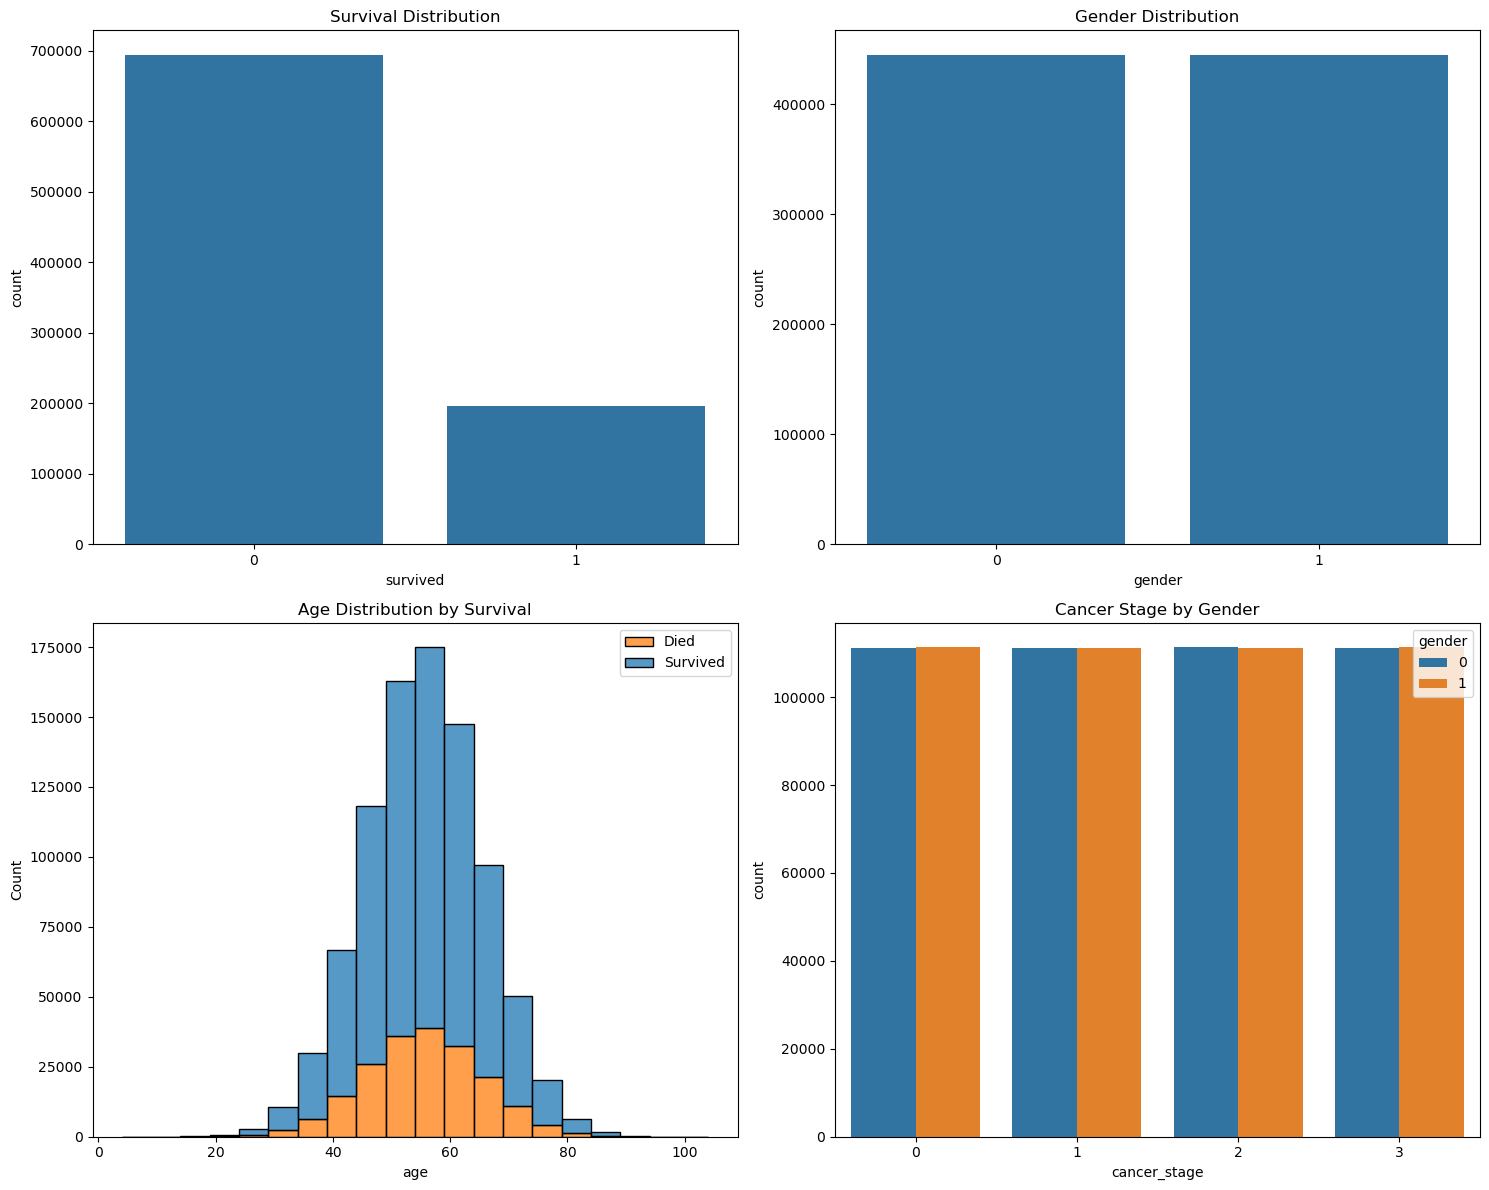

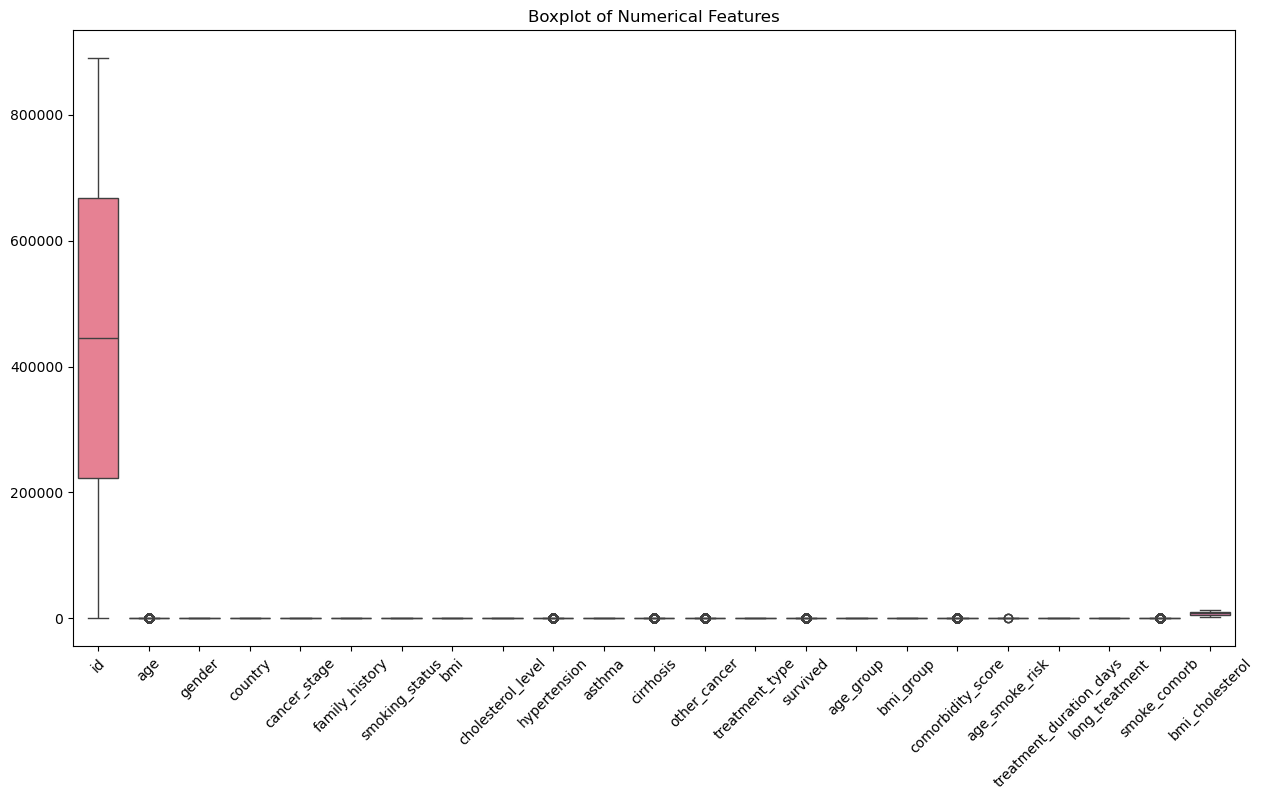

In [28]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Survival distribution
sns.countplot(x='survived', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Survival Distribution')

# Gender distribution
sns.countplot(x='gender', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution')

# Age distribution by survival
sns.histplot(data=df, x='age', hue='survived', multiple='stack',
             bins=20, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Survival')
axes[1, 0].legend(['Died', 'Survived'])

# Cancer stage by gender
sns.countplot(x='cancer_stage', hue='gender', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Cancer Stage by Gender')

plt.tight_layout()
plt.show()

# Outlier detection
plt.figure(figsize=(15, 8))
sns.boxplot(data=df.select_dtypes(include=np.number))
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=45)
plt.show()

In [11]:
# ===== DATA PREPROCESSING =====
le = LabelEncoder()
# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))


In [12]:
df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,...,end_treatment_date,survived,age_group,bmi_group,comorbidity_score,age_smoke_risk,treatment_duration_days,long_treatment,smoke_comorb,bmi_cholesterol
0,1,64.0,1,26,2016-04-05,0,1,3,29.4,199,...,2017-09-10,0,2,2,1,192.0,523,1,3,5850.6
1,2,50.0,0,19,2023-04-20,2,1,3,41.2,280,...,2024-06-17,1,1,1,2,150.0,424,1,6,11536.0
2,3,65.0,0,12,2023-04-05,2,1,1,44.0,268,...,2024-04-09,0,2,1,2,65.0,370,1,2,11792.0
3,4,51.0,0,1,2016-02-05,0,0,3,43.0,241,...,2017-04-23,0,1,1,2,153.0,443,1,6,10363.0
4,5,37.0,1,17,2023-11-29,0,0,3,19.7,178,...,2025-01-08,0,3,0,0,111.0,406,1,0,3506.6


In [13]:
df.drop(['diagnosis_date', 'end_treatment_date'], axis=1, inplace=True)


In [14]:
X = df.drop("survived", axis=1)
y = df["survived"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [22]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
from imblearn.over_sampling import SMOTE

# After train-test split
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)


In [ ]:
# ===== MODEL TRAINING =====
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5,
                                          min_samples_leaf=3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10,
                                          min_samples_split=5, random_state=42,class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                            random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [24]:
from sklearn.metrics import (
    accuracy_score, classification_report,
    precision_recall_curve, auc, f1_score
)

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}...")
    model.fit(X_train_res, y_train_res)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    report = classification_report(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score (Class 1): {f1:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("Classification Report:\n", report)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'pr_auc': pr_auc,
        'report': report
    }


Training Logistic Regression...

Logistic Regression Performance:
Accuracy: 0.4907
F1-score (Class 1): 0.3100
PR AUC: 0.2215
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.48      0.60    138799
           1       0.22      0.52      0.31     39201

    accuracy                           0.49    178000
   macro avg       0.50      0.50      0.45    178000
weighted avg       0.66      0.49      0.53    178000

Logistic Regression model stored in results dictionary.

Training Decision Tree...

Decision Tree Performance:
Accuracy: 0.3227
F1-score (Class 1): 0.3462
PR AUC: 0.2218
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.18      0.30    138799
           1       0.22      0.81      0.35     39201

    accuracy                           0.32    178000
   macro avg       0.50      0.50      0.32    178000
weighted avg       0.66      0.32      0.31    178000

De

c:\Users\himan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:20:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Performance:
Accuracy: 0.7798
F1-score (Class 1): 0.0000
PR AUC: 0.2205
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88    138799
           1       0.00      0.00      0.00     39201

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000

XGBoost model stored in results dictionary.


c:\Users\himan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\himan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\himan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Reduce search space to avoid overloading system
param_grid = {
    'n_estimators': [50],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

brf = BalancedRandomForestClassifier(random_state=42, n_jobs=1)  # Limit to 1 CPU core

random_search = RandomizedSearchCV(
    estimator=brf,
    param_distributions=param_grid,
    scoring='f1',
    cv=3,
    n_iter=4,  # Try 4 combinations only
    n_jobs=1,
    random_state=42,
    verbose=1
)
random_search.fit(X_train_res, y_train_res)
best_brf = random_search.best_estimator_


c:\Users\himan\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


c:\Users\himan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\himan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\himan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\himan

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score

# Predict test set
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
f1 = f1_score(y_test, y_pred)

# Print results
print("✅ Final Balanced Random Forest Model Performance:")
print(f"F1-score (Class 1): {f1:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
